In [1]:
import numpy as np
import optimizers
import measures
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
X, y = make_moons()

In [2]:
class LogisticRegression:
    def __init__(self, optimization, **kwargs):
        self.optimization = optimization
        self.kwargs=kwargs
        self.losses = None
        self.is_trained = False
        self.__is_optimization_known(optimization)
        if optimization == 'Gradient Descent':
            self.__optimizer = optimizers.GradientDescent(**self.kwargs)
        elif optimization == 'Stochastic Gradient Descent':
            self.kwargs['batch_size'] = 1
            self.__optimizer = optimizers.GradientDescent(**self.kwargs)
        elif optimization == 'Iterative Reweighted Least Squares':
            raise NotImplementedError('IRLS not implemented yet')
        elif optimization == 'Adaptive Moment Estimation':
            raise NotImplementedError('Adam not implemented yet')
            
    @staticmethod
    def __is_optimization_known(o):
        if o not in ['Gradient Descent', 'Stochastic Gradient Descent',
                     'Iterative Reweighted Least Squares', 'Adaptive Moment Estimation']:
            raise ValueError(f'Unknown optimization {o}')

    def train(self, X, y):
        #todo: check the dimensions?
        self.__optimizer.train(X, y)
        
    def predict(self, X):
        return self.__optimizer.predict(X)
    
    def get_optimizer_training_losses(self):
        return self.__optimizer.losses

In [3]:
lr_gd = LogisticRegression(optimization='Gradient Descent', learning_rate=0.01, epochs=50, batch_size=10)

In [4]:
lr_gd.train(X, y)

Early stopping



In [5]:
lr_sgd = LogisticRegression(optimization='Stochastic Gradient Descent', learning_rate=0.01, epochs=50)

In [6]:
lr_sgd.train(X, y)

Early stopping



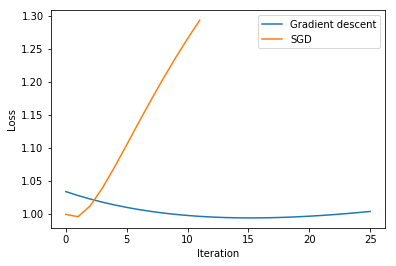

In [7]:
l_gd = lr_gd.get_optimizer_training_losses()
l_sgd = lr_sgd.get_optimizer_training_losses()
plt.plot(range(len(l_gd)), l_gd, label='Gradient descent')
plt.plot(range(len(l_sgd)), l_sgd, label='SGD')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [8]:
p_gd = lr_gd.predict(X)
p_sgd = lr_sgd.predict(X)

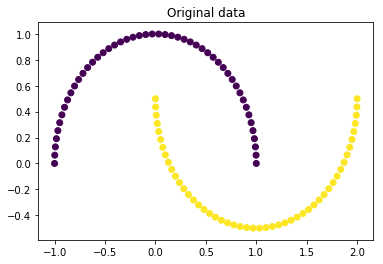

In [9]:
plt.scatter(*X.T, c=y)
plt.title('Original data')
plt.show()

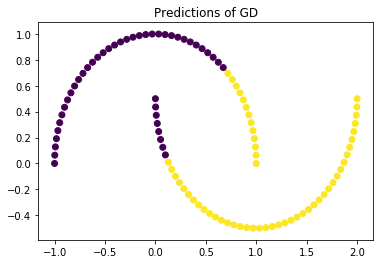

In [10]:
plt.scatter(*X.T, c=p_gd)
plt.title('Predictions of GD')
plt.show()

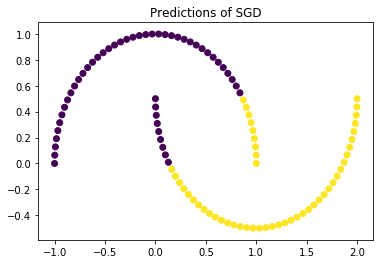

In [11]:
plt.scatter(*X.T, c=p_sgd)
plt.title('Predictions of SGD')
plt.show()